# Neurasmus, models of synaptic activity

In the previous workshop, we have discussed models of neural activity.

 We now focus on modeling the activity of synapses themselves.

### **A simple model of synaptic transmission**

#### **Introduction**



Synaptic transmission can be divided into three steps.

**1:** Neurotransmitter release,

**2:** Channel response,

**3:** Synaptic current and post synaptic potential response.

####**1: Neurostransmitter release**



**Neurostransmitters** are released from a vesicle in an axon bouton when the presynaptic neuron emits an action potential.

Given the small volume of the synaptic cleft (synpases are about 10-20 nm wide), the evolution of neurotransmitter concentration in the synaptic cleft is very fast.

The characteristic time constant of neurotransmitter concentration is $\sim 0.1 ms$

In models of synaptic transmission, one often assumes an instantaneous rise of neurotransmitter concentration when the vesicle opens and an exponential decrease as neurotransmitters diffuse out of the synaptic cleft and/or are recaptured.


We write a simple function that simulates the time course of neurotransmitter concentration in the synaptic cleft.

This example considers glutamate, an important exictatory neurotransmitter that can bind to AMPA and NMDA receptors.

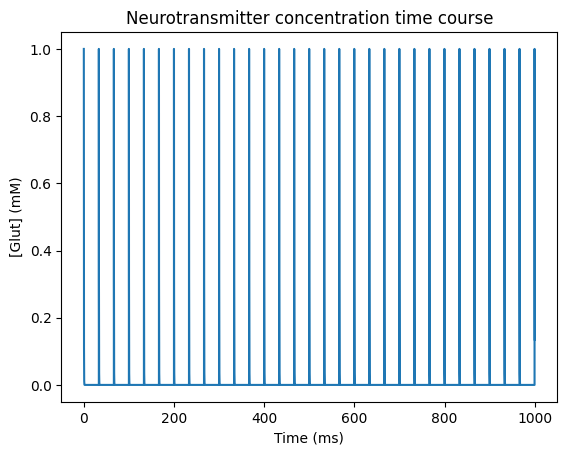

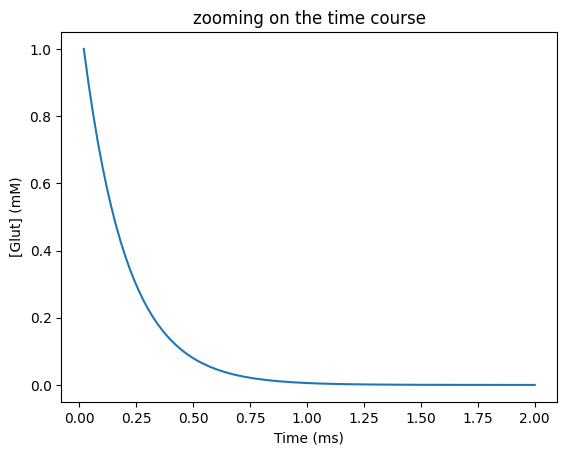

In [27]:
#A simple model of neurotransmitter release

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy

def NeurTrans_release(freq, Sim_dur):
  #This function simulates the neurotransmitter concentration in the synapse
  #INPUT: freq, a positive real number, the frequency of neurotransmitter release
  #OUTPUT: Time_Vec, a real vector, time ponts of the simulation
  #Glut_Conc_Vec, a real vector, neurotransmitter concentration

  tau_glut=0.2#ms time constant of glutamate
  dt=0.02 #ms
  unit_release=1 #mM neurotransmitter concentration due to a single event

  Nstep_int=math.floor(1000/(freq*dt))# number of time steps between synaptic events
  Nstep_tot=math.floor(Sim_dur/dt)#Total number of time steps in the simulation

  Time=0
  Time_Vec=[]
  GlutConc_Vec=[]
  GlutConc=0
  for j in range(Nstep_tot):
    Time=Time+dt
    GlutConc=GlutConc-GlutConc*dt/tau_glut#This line computes the exponential decay
    if j/Nstep_int==math.floor(j/Nstep_int):
      GlutConc=GlutConc+unit_release #Instantaneous increase in case of a synaptic event.
    GlutConc_Vec.append(GlutConc)
    Time_Vec.append(Time)
  return Time_Vec, GlutConc_Vec

Time_Vec, GlutConc_Vec=NeurTrans_release(30,1000)

#Plotting the results
plt.plot(Time_Vec,GlutConc_Vec)
plt.xlabel('Time (ms)')
plt.ylabel('[Glut] (mM)')
plt.title('Neurotransmitter concentration time course')
plt.show()

plt.plot(Time_Vec[0:100],GlutConc_Vec[0:100])
plt.xlabel('Time (ms)')
plt.ylabel('[Glut] (mM)')
plt.title('zooming on the time course')
plt.show()

####**2: Channel response**

After being released in the synapse, neurotransmitters bind to *postsynaptic receptors*.

When enough neurotransmitters (usually 1,2 or 3) are bound to a given receptor, this receptor can open.

The metaphor of keys (the transmitters) an keyholes (the receptors) is often used.

Receptors can be in several *close*, *open* or *desensitized* states.

They switch stochastically between states according to a *Markov process*.  

To avoid the resource consuming description of individual channels, a common approach is to treat the number of channels in each state as a continous proportion.

The evolution of channel states can described by a system of ordinary differential equations.

A schematic illustrating the possible receptor state transitions from Xiaoting et al.

doi: 10.3389/fncom.2022.969119



**A simple model**

For the sake of exposition, we implement a simpler model.

We consider channels with the following possible states.

**C0:** Closed with no bound neurotransmitter

**C1:** Closed with 1 bound neurotransmitter

**C2:** Closed with 2 bound neurotransmitters

**O:** Open

**D:** Desensitized

We consider the following transition scheme
$$
C0\rightleftharpoons_{k1off}^{k1on}C1\rightleftharpoons_{k2off}^{k2on}C2\rightleftharpoons_{k3off}^{k3on}O\rightleftharpoons_{k3off}^{k3on}D
$$

Each transition requires the specification of a forward rate constant and of a backward rate constant.

When the transition corresponds to the binding of a transition, the rates have to be multplied by the concentration of neurotransmitters.

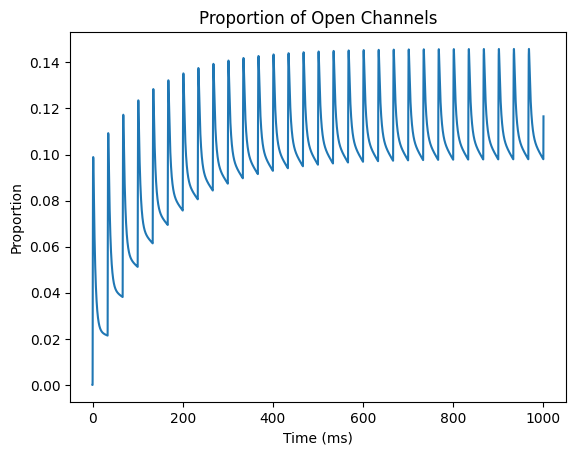

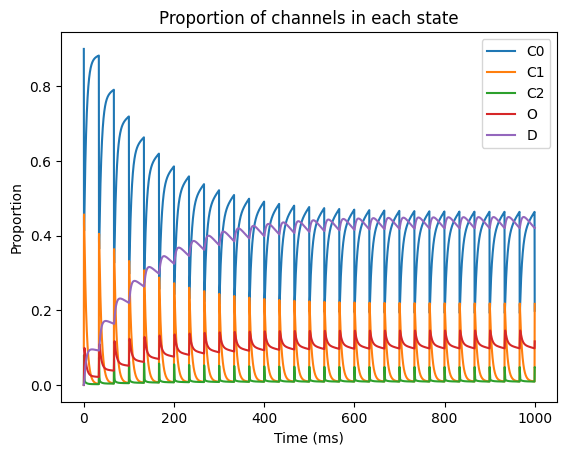

In [28]:
#A simple model of channel of channel response

class Rate:
  #Specifying the transition rates
  k1on=5# (/mM ms)
  k1off=0.2# (/ms)
  k2on=2.5# (/mM ms)
  k2off=0.2#(/ms)
  k3on=2#(/ms)
  k3off=0.2#(/ms)
  k4on=0.2#(/ms)
  k4off=0.05#(/ms)  #When channels are in a desensitized state, they stay there for a  long time.  So k4off is small


def Channel_Response(freq, Sim_dur,Rate):
  #This function computes the response of synaptic channels to an application of neurotransmitters
  #INPUT: freq, a positive real, the frequency of neurotransmitter release
  #Sim_dur, a positive real, the duration of the simulation
  #Rate, a class that contains the channel transition rates
  #OUTPUT: Time_Vec, a real vector containing the time points of the simulation.
  #C1_Vec, C2_Vec, O_Vec, D_Vec, real vectors, the proportion of channels in each state

  Time_Vec, GlutConc_Vec=NeurTrans_release(freq,Sim_dur)#Simulating the time course of neurotransmitters in the synapse

  dt=0.02 #ms

  #Specifying the initial state of the receptors.  At the beginning of the simulation, all channels are closed with no neurotransmitters attached
  C0=1
  C1=0
  C2=0
  O=0
  D=0

  #Defining vectors that will contain the results
  C0_Vec=[]
  C1_Vec=[]
  C2_Vec=[]
  O_Vec=[]
  D_Vec=[]

  Time_Vec=[]
  time=0
  Nstep_tot=math.floor(Sim_dur/dt)


  #Main loop
  for j in range(Nstep_tot):
    time=time+dt
    Reac1=C0*Rate.k1on*dt*GlutConc_Vec[j]-C1*Rate.k1off*dt
    Reac2=C1*Rate.k2on*dt*GlutConc_Vec[j]-C2*Rate.k2off*dt
    Reac3=C2*Rate.k3on*dt-O*Rate.k3off*dt
    Reac4=O*Rate.k4on*dt-D*Rate.k4off*dt

    C0=C0-Reac1
    C1=C1+Reac1-Reac2
    C2=C2+Reac2-Reac3
    O=O+Reac3-Reac4
    D=D+Reac4

    C0_Vec.append(C0)
    C1_Vec.append(C1)
    C2_Vec.append(C2)
    O_Vec.append(O)
    D_Vec.append(D)

    Time_Vec.append(time)

  return Time_Vec,C0_Vec, C1_Vec, C2_Vec, O_Vec, D_Vec

Time_Vec, C0_Vec, C1_Vec, C2_Vec, O_Vec, D_Vec=Channel_Response(30, 1000, Rate)

#Plotting the results
plt.plot(Time_Vec,O_Vec)
plt.xlabel('Time (ms)')
plt.title('Proportion of Open Channels')
plt.ylabel('Proportion')
plt.show()

plt.plot(Time_Vec,C0_Vec,Time_Vec,C1_Vec,Time_Vec,C2_Vec,Time_Vec,O_Vec,Time_Vec,D_Vec)
plt.xlabel('Time (ms)')
plt.ylabel('Proportion')
plt.legend(['C0','C1','C2','O','D'])
plt.title('Proportion of channels in each state')
plt.show()



**Channel desensitization**

In the above example, we observe an increase in the proportion of open channels during the few first events.

*Densitization* can also cause the opposite effect.

Let's decrease the k4off by a factor 10 and see what happens.

Such a decrease should increase the time that channels spend in the desensitized state.

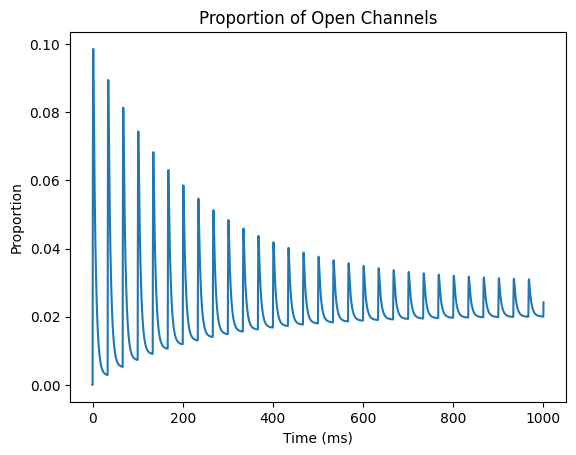

In [29]:
Rate_modif=Rate
Rate_modif.k4off=Rate.k4off/10#(/ms)


Time_Vec, C0_Vec, C1_Vec, C2_Vec, O_Vec, D_Vec=Channel_Response(30, 1000, Rate_modif)

#Plotting the results
plt.plot(Time_Vec,O_Vec)
plt.xlabel('Time (ms)')
plt.title('Proportion of Open Channels')
plt.ylabel('Proportion')
plt.show()


The observed decrease of synaptic conductance in response to repeated stimulation is called *desensitization*.  

This can be observed in real neurons when the spike rate is high.


#### **3: Synaptic current and postsynaptic membrane potential response**


When channels are open, current can flow through the synapse.

This current is mediated by the flow of ions such as chloride, sodium, potassium and calcium through the membrane

Synapses have a **synaptic reversal potential** denoted by $E_{syn}$.

There is no current synaptic current if the membrane potential $V_m$ is equal to the synaptic reversal potential.

The  *driving force* is defined as the difference between the membrane potential and the synaptic reversal potential.  

The synaptic current is proportional to the driving force

$I_{syn}=g_{syn}(E_{syn}-V_m)$.

Here $g_{syn}$ is the synaptic conductance it is equal to the maximal conductance $g_{syn,max}$ times the fraction of open channels.

The membrane resting potential is around -60 mV.

Reversal potential of *excitatory synapses* is above the resting potential, around 0 mV for AMPA synapses.

Reversal potential of *inhibitory synapses* is below the resting potential, around -70 mV for GABA synapses.

The simplest case is to consider the membrane potential to be constant  and measure the synaptic current.

Experimentally, this corresponds to a *voltage-clamp* setting.


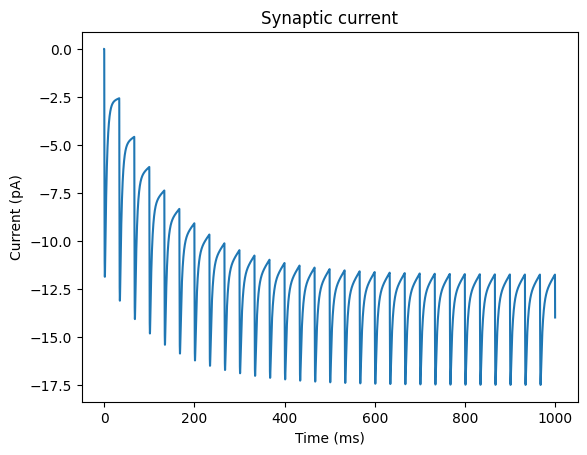

In [30]:

class Rate:
  #Specifying the transition rates
  k1on=5# (/mM ms)
  k1off=0.2# (/ms)
  k2on=2.5# (/mM ms)
  k2off=0.2#(/ms)
  k3on=2#(/ms)
  k3off=0.2#(/ms)
  k4on=0.2#(/ms)
  k4off=0.05#(/ms)

def Syn_Cur(freq,Sim_dur,Rate):
  #This function computes the synaptic current
  #INPUT: freq a positive real, the frequency of neurotramitter release
  #Sim_dur, a positive real, the duration of the simulation
  #Rate, a class that contains the transition rates between channels
  #OUTPUT:Time_Vec, a real vector that contains the time points of the simulation
  #Isyn_Vec, a real vector, the current value

  Time_Vec, C0_Vec, C1_Vec, C2_Vec, O_Vec, D_Vec=Channel_Response(30, 1000, Rate)#simulating the channel states


  dt=0.02 #ms
  Nstep_tot=math.floor(Sim_dur/dt)#number of time steps in the simulation

  #Cell parameters
  g_syn_max=2#(nS)
  Esyn=0#(mV)
  Vm=-60 #(mV)


  Isyn_Vec=[]#(pA)

  #Main Loop
  for j in range(Nstep_tot):
    Isyn=g_syn_max*O_Vec[j]*(Vm-Esyn)
    Isyn_Vec.append(Isyn)

  return Time_Vec, Isyn_Vec

Time_Vec, Isyn_Vec=Syn_Cur(30,1000,Rate)

#Plotting the result
plt.plot(Time_Vec,Isyn_Vec)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Synaptic current')
plt.show()




A more physiological situation is one in which the membrane potential can change with time according to the formula

$C\frac{dV_m}{dt}=-I$.

Here $C$ is the cell capacitance and $I$ is the sum of all transmembrane currents.

 We will consider two types of currents, the *synaptic current* and the *leak current*.  



*   The leak current  is given by

$I_L=g_L(V_m-E_L)$

where $E_L$ is the leak potential. Typical values of $E_L$ are around $-65$ mV.

*   The synaptic is current given by

$I_{syn}=g_{syn}(V_m-E_{syn})$.

These equations for the membrane potential are often explained by a simple electric diagram.


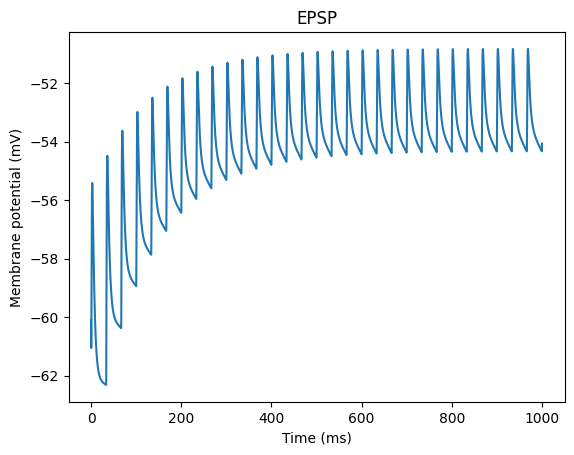

In [31]:
#A simple model of posynaptic membrane response
class Rate:
  #Specifying the transition rates
  k1on=5# (/mM ms)
  k1off=0.2# (/ms)
  k2on=2.5# (/mM ms)
  k2off=0.2#(/ms)
  k3on=2#(/ms)
  k3off=0.2#(/ms)
  k4on=0.2#(/ms)
  k4off=0.05#(/ms)

def Syn_Pot(freq,Sim_dur,Rate):
  #This function computes the post-synaptic potential
  #INPUT: freq a positive real, the frequency of neurotramitter release
  #Sim_dur, a positive real, the duration of the simulation
  #Rate, a class that contains the transition rates between channels
  #OUTPUT:Time_Vec, a real vector that contains the time points of the simulation
  #Vm_Vec, a real vector, values of postsynaptic membrane potential

  Time_Vec, C0_Vec, C1_Vec, C2_Vec, O_Vec, D_Vec=Channel_Response(freq, 1000, Rate)#We simulate the state of the channels
  dt=0.02 #ms
  Nstep_tot=math.floor(Sim_dur/dt)#number of time steps in the simulation

  #Specifying cell parameters
  g_L=1#(nS)
  EL=-65#(mV)
  Vm=-60 #(mV)
  C=1 #(pF)
  g_syn_max=2#(nS)
  Esyn=0#(mV)

  #Initializing response vectors
  Vm_Vec=[]#(mV)
  Isyn_Vec=[]#(pA)
  IL_Vec=[]#(pA)


  #Main loop
  for j in range(Nstep_tot):
    Isyn=g_syn_max*O_Vec[j]*(Vm-Esyn)
    IL=g_L*(Vm-EL)
    Vm=Vm+dt*(-IL-Isyn)/C
    Vm_Vec.append(Vm)
    Isyn_Vec.append(Isyn)

  return Time_Vec, Vm_Vec

Time_Vec, Vm_Vec=Syn_Pot(30,1000,Rate)

#Plotting the results
plt.plot(Time_Vec,Vm_Vec)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('EPSP')
plt.show()

**Takeaway:** Synaptic conductance is well approximated by an instantaneous rise followed by an exponential decrease. This approximation is often used in models of neural network.


#### **Exercice**

Open the research paper

https://www.frontiersin.org/journals/computational-neuroscience/articles/10.3389/fncom.2022.969119/full

implement the model of synaptic channel described in figure 1 of the paper.

The goal is to create a more complex model with several desensitized states.

### **Extracting information from the measurement of membrane potential**



*   One can extract useful information on the synaptic properties from measurements of the membrane potential.

*   Typically, measureaments are the addition of the real membrane potential and unbiased noise.

*   The most direct feature of a synaptic event is the amplitude of the response.  This amplitude allows to compare the number of receptor channels between synpases as a larger number of channels leads to a larger response.

*   The time course of the membrane potential can also provide information on synaptic properties.

*   Usually, an exponential is fitted to the measured potential. The time constant of the exponential provides information on the rate constant of synaptic transition.

Let's relaunch the simulation with a smaller frequency so individual events can be better.

Let's add some noise to mimick realistic experimental measurements.

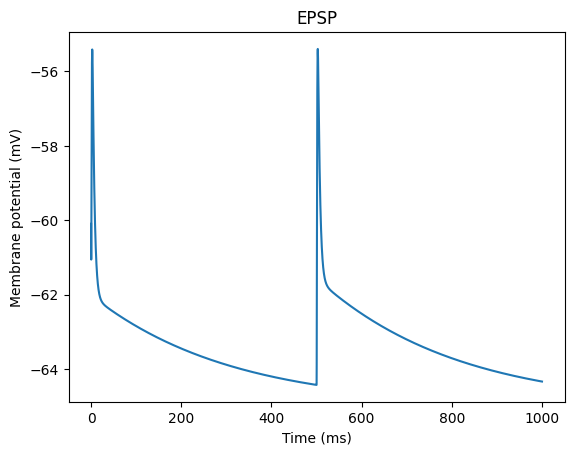

In [32]:
Time_Vec, Vm_Vec=Syn_Pot(2,1000,Rate)

#Plotting the results
plt.plot(Time_Vec,Vm_Vec)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('EPSP')
plt.show()

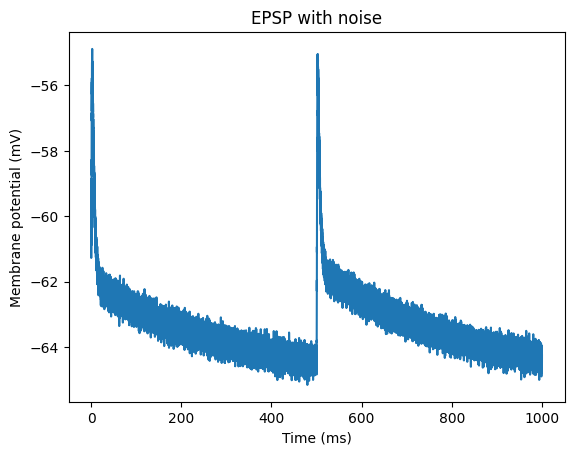

In [33]:
Nstep_tot=len(Time_Vec)

#Adding noise
noise_amp=0.2
noise_vec=[]
for j in range(Nstep_tot):
  noise=np.random.normal(0, noise_amp, 1)
  noise_vec.append(noise[0])

Mesured_potential=[]
for j in range(Nstep_tot):
  Measured=noise_vec[j]+Vm_Vec[j]
  Mesured_potential.append(Measured)

#Plotting the simulated measured potential
plt.plot(Time_Vec,Mesured_potential)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('EPSP with noise')
plt.show()


We focus on the decay phase of the signal.

Visually, there appears two components in the decay, a fast and a slow one.

To investigate the fast component of the decay, we select a region of interest in the trace, say between 505 ms and 550 ms.

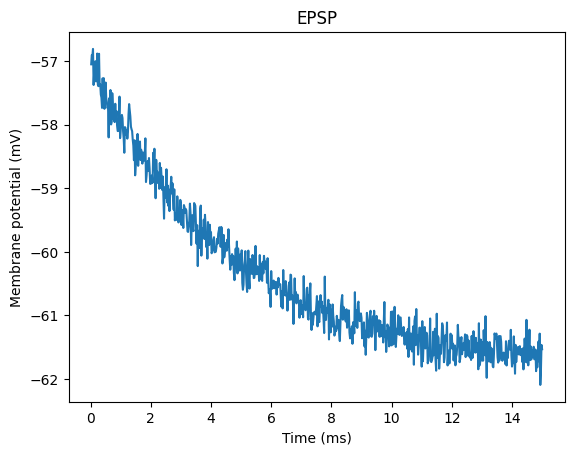

In [34]:
#Selecting the region of interest
Indices_Select = [idx for idx, val in enumerate(Time_Vec) if val > 505 and val<520]
Time_Vec_Select=[]
Vm_Vec_Select=[]
for j in Indices_Select:
  Time_Vec_Select.append(Time_Vec[j]-505)
  Vm_Vec_Select.append(Mesured_potential[j])

#Plotting the region of interest
plt.plot(Time_Vec_Select,Vm_Vec_Select)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('EPSP')
plt.show()


We now fit an exponential on this curve to indentify the amplitude and the decay rate constant (fast component) of the signal.

In [35]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b
xs = np.array(Time_Vec_Select)
ys = np.array(Vm_Vec_Select)
p0 = (-61, .1, 4)


params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
Tau=1/params[1]
print('Amplitude= '+str(params[0])+' mV')
print('Decay time constant of membrane potential= ' +str(Tau)+' (ms)')

Amplitude= 4.7865436185520505 mV
Decay time constant of membrane potential= 4.656472902265265 (ms)


We get an amplitude around 4.8 mV and a time constant of approximatively 4.6 ms.

Due to the random nature of the noise, slight variations can be observed between each run of the code.

We now increase the simulated binding affinity by multiplying the constants k1on and k2on.  This could correspond to the application of a drug that increases affinity.

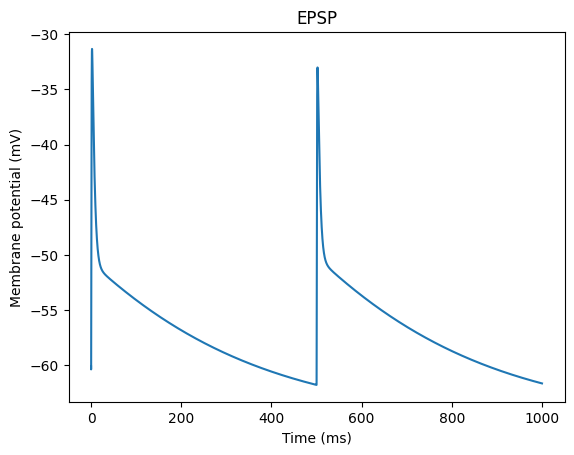

In [36]:
class Rate:
  #Specifying the transition rates
  k1on=5# (/mM ms)
  k1off=0.2# (/ms)
  k2on=2.5# (/mM ms)
  k2off=0.2#(/ms)
  k3on=2#(/ms)
  k3off=0.2#(/ms)
  k4on=0.2#(/ms)
  k4off=0.05#(/ms)


Rate_with_Drug=Rate
Rate_with_Drug.k1on=5*Rate.k1on
Rate_with_Drug.k2on=5*Rate.k2on

Time_Vec, Vm_Vec=Syn_Pot(2,1000,Rate_with_Drug)

#Plotting the results
plt.plot(Time_Vec,Vm_Vec)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('EPSP')
plt.show()


Again, let make some noise to simulate realistic measurements.

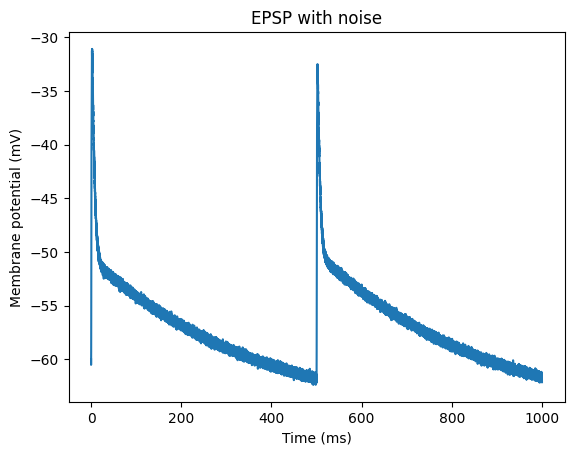

In [37]:
Nstep_tot=len(Time_Vec)

#Adding noise
noise_amp=0.2
noise_vec=[]
for j in range(Nstep_tot):
  noise=np.random.normal(0, noise_amp, 1)
  noise_vec.append(noise[0])

Mesured_potential=[]
for j in range(Nstep_tot):
  Measured=noise_vec[j]+Vm_Vec[j]
  Mesured_potential.append(Measured)

#Plotting the simulated measured potential
plt.plot(Time_Vec,Mesured_potential)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('EPSP with noise')
plt.show()


As in the case without drug, we select the part of the trace between 505 ms and 520 ms to focus on the rapid phase of the decay.

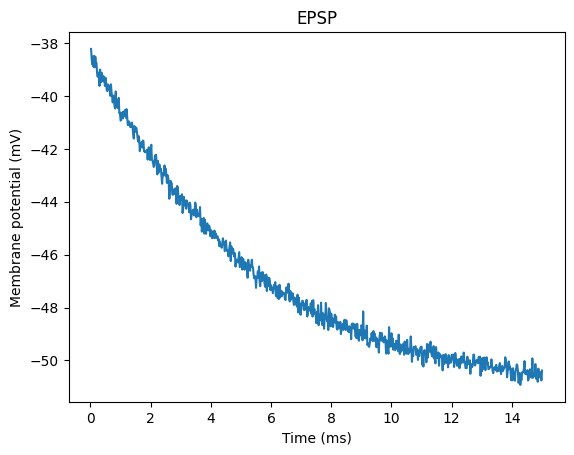

In [38]:
#selecting the region
Indices_Select = [idx for idx, val in enumerate(Time_Vec) if val > 505 and val<520]
Time_Vec_Select=[]
Vm_Vec_Select=[]
for j in Indices_Select:
  Time_Vec_Select.append(Time_Vec[j]-505)
  Vm_Vec_Select.append(Mesured_potential[j])

#Plotting the result
plt.plot(Time_Vec_Select,Vm_Vec_Select)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('EPSP')
plt.show()

Again, we fit an exponential to the 'data'

In [39]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b
xs = np.array(Time_Vec_Select)
ys = np.array(Vm_Vec_Select)
p0 = (-61, .1, 4)


params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
Tau=1/params[1]
print('Time constant=' +str(Tau)+ ' (ms)')
print('Amplitude= '+str(params[0])+' (mV)')

Time constant=5.337116816252869 (ms)
Amplitude= 13.082136335205467 (mV)


We observe a small increase in the time constant and a large incease in the amplitude of the synaptic response.

#### **Exercice**

The change in rate constant in the previous example led to a large increase in amplitude and a small increase in the time constant.  

Find a change in rate constants which would mainly impact the time constant.

### **Ionic regulation and synaptic currents**

We have seen that ionic current is proportional to the difference between the **synaptic potential** and **membrane potential**.  

*Where does the synaptic potential comes from?*

Synaptic channels as other channels are permeable to different ionic species.

If a synapse is permeable to only one ionic specie, the synaptic potential is equal to the ionic reversal potential given by the **Nernst equation**:

$$
E_x=\frac{RT}{zF}\log \left(\frac{[x]_o}{[x]_i}\right).
$$

Here, $R$ is the perfect gas constant, $F$ the Faraday constant $T$ the absolute temperature and $z$ is the valence of the ion. Also, $[x]_o$ and $[x]_i$  denote the extracellular concentrations.

The ionic reversal potential $E_x$ corresponds to the value of the membrane potential for whihc there is no net flux of ion $x$ through the membrane.



#### **Chloride regulation**

Let's give an example to illustrate how chloride reversal potential $E_{Cl}$ depends on the intra and extracellular concentrations of chloride.

In [40]:
def Nernst(T,ci,co,z):
  #Computes the Nernst potential of an ionic specie
  #INPUT
  #T, absolute temperature
  #ci, co intra and extra ionic concentrations
  #z, valence of the ion
  #OUTPUT
  #revpot, Nernst reversal potential
  R=8.3144
  F=96485
  revpot=1000*(R*T/(F*z))*np.log(co/ci)
  return revpot

Let's run this function for a wide range of intracellular chloride concentration values

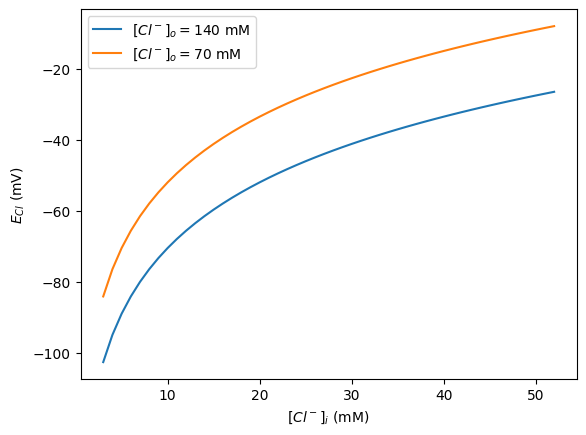

In [41]:


z=-1
T=310

co_140=140
co_70=70
ECl_140=[]
ECl_70=[]
cli_vec=[]
for j in range(50):
  cli=j+3
  cli_vec.append(cli)
  co=140
  ECl=Nernst(T,cli,co,z)
  ECl_140.append(ECl)
  co=70
  ECl=Nernst(T,cli,co,z)
  ECl_70.append(ECl)

#Let's plot the results
plt.plot(cli_vec,ECl_140,cli_vec,ECl_70)
plt.legend(['$[Cl^-]_o=140$ mM', '$[Cl^-]_o=70$ mM'])
plt.xlabel('$[Cl^-]_i$ (mM)')
plt.ylabel('$E_{Cl}$ (mV)')
plt.show()

The **Goldman-Hodgkin-Katz equation** is used when the synaptic channels are permeable to many ion types.  It provides a relation between the ionic concentrations and the synaptic potential.

For excitatory synapses permeable to sodium and potassium, it is given by
$$
E_{syn}=\frac{RT}{F}\log\left(\frac{P_K[K^+]_o+P_{Na}[Na^+]_o}{P_K[K^+]_i+P_{Na}[Na^+]_i}\right).
$$

Here, $P_X$ denote the relative permeability of the membrane with respect to ion $X$.

GABAergic and glycinergic synapses are inhibitory synapses.  They are permeable to both bicarbonate and chloride ions.  The reversal potential of GABA synapses is given by
$$
E_{syn}=\frac{RT}{F}\log\left(\frac{P_{Cl}[Cl^-]_i+P_{HCO3}[HCO_3^-]_i}{P_{Cl}[Cl^-]_o+P_{HCO3}[HCO_3^-]_o}\right)
$$

GABA synapses are more permeable to chloride ions than to bicarbonate ions.  A typical ratio is $P_{Cl}/P_{HCO3}=4$.

Let's compute a typical value for the reversal potential of GABA synapses

In [42]:
import numpy as np
print('Lets compute a typical EGABA value')

R=8.3144
T=310
F=96450
PCl=1
PHCO3=0.25
Cli=10
Clo=140
HCO3i=15
HCO3o=35

EGABA=1000*(R*T/F)*np.log((PCl*Cli+PHCO3*HCO3i)/(PCl*Clo+PHCO3*HCO3o))

print('EGABA ='+str(EGABA)+' mV')


Lets compute a typical EGABA value
EGABA =-63.634318441070356 mV


The GABA synaptic potential is highly sensitive to the intracellular chloride concentration.

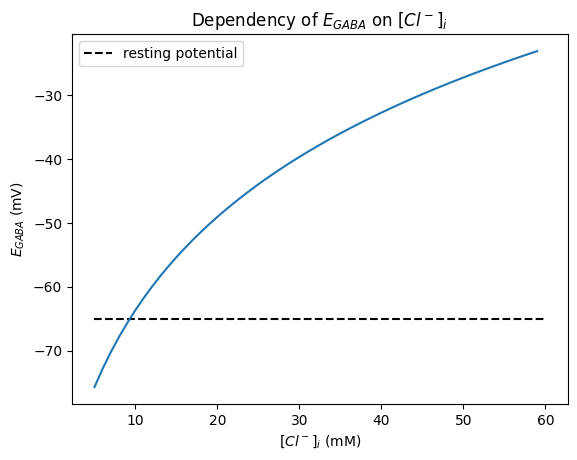

In [43]:
from matplotlib import pyplot as plt

#We compute the value EGABA over a range of [Cl-]i values
EGABAvec=[]
Clivec=[]
for j in range(55):
  Cli=j+5
  EGABA=1000*(R*T/F)*np.log((PCl*Cli+PHCO3*HCO3i)/(PCl*Clo+PHCO3*HCO3o))
  Clivec.append(Cli)
  EGABAvec.append(EGABA)

#plotting the results
plt.plot([5,60],[-65,-65],'--k',Clivec,EGABAvec)
plt.xlabel('$[Cl^-]_i$ (mM)')
plt.ylabel('$E_{GABA}$ (mV)')
plt.title('Dependency of $E_{GABA}$ on $[Cl^-]_i$')
plt.legend(['resting potential'])
plt.show()


The case of chloride is interesting.

This ion is the main mediator of fast inhibition in the mammalian brain.

 The intracellular concentration of chloride changes during development as well as a result of diverse pathologies. Chloride current switches from depolarizing to hyperpolarizing during development.

Recall that for sodium and potassium ions, there is a pump using the energy of ATP molecules to create a transmembrane concentration gradient.

For chloride, things are different.  In adult, chloride is transported accross the membrane by cotransporters such as **KCC2**.

**KCC2** transports one chloride ion together with one potassium.

One can say that KCC2 uses the energy of the potassium gradient to extrude chloride from the cell.

In the immature animal, chloride is imported into the cell by **NKCC1** that we will not discuss here.

A common assumption when modelling KCC2 activity is the the chloride flux through the cotransporter is proportional to the difference between chloride reversal potential and potassium reversal potential.

The intracellular chloride concentration results from an equilibrium between the chloride influx through GABA synapses and  the chloride efflux through KCC2.

Let's compute the equilibrium intracellular concentration under several conditions.

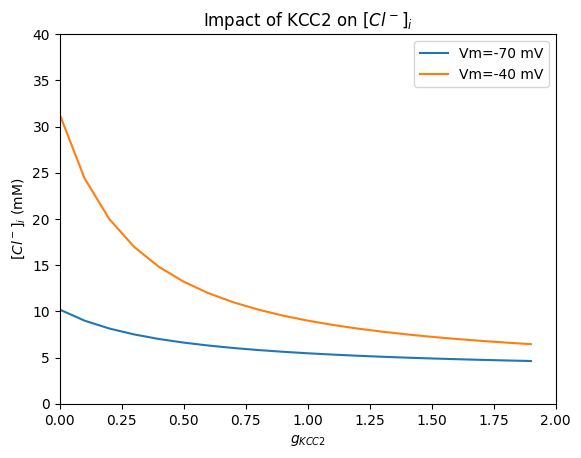

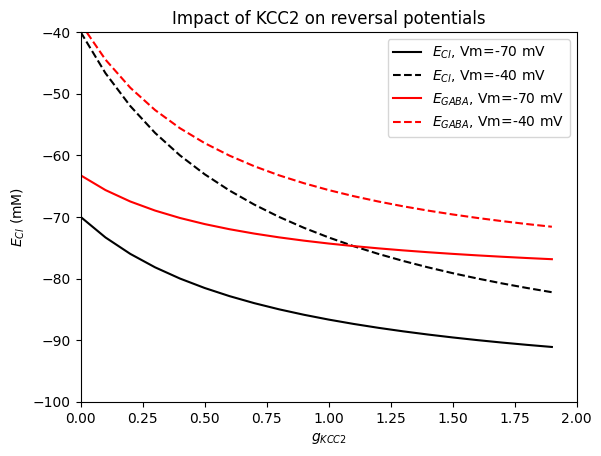

In [44]:
import math

def eqCli(gGABA,gKCC2,Vm):
  #Computes the equilibrium chloride concentration
  #INPUT
  #gGABA, a positive real number, conductance of the GABA synapse
  #gKCC2, a positive real number, strength of the KCC2 cotransporter
  #Vm, a real number, membrane potential
  #OUTPUT:
  #Cli, a positive real number, intracellular chloride concentration
  #ECl, a real number, chloride reversal potential
  #EGABA,  a real number, the reversal potential of gaba synapses
  Clo=140
  HCO3i=15
  HCO3o=35
  PCl=0.8
  PHCO3=0.2
  F=96485
  R=8.3144
  T=310
  EK=-100
  #gKCC*(EK-ECl)=0.8*gGABA*(ECl-Vm)
  ECl=(gKCC2*EK+0.8*gGABA*Vm)/(gKCC2+0.8*gGABA)
  Cli=Clo*math.e**((F/(1000*R*T))*ECl)
  EGABA=1000*(R*T/F)*np.log((PCl*Cli+PHCO3*HCO3i)/(PCl*Clo+PHCO3*HCO3o))
  return Cli, ECl,EGABA

#Launching the simulations
gGABA=1
Cli_vec_m70=[]
Cli_vec_m40=[]
gKCC2_vec=[]
ECl_vec_m70=[]
ECl_vec_m40=[]
EGABA_vec_m70=[]
EGABA_vec_m40=[]
Ivec_m40=[]
Ivec_m70=[]

for j in range(20):
  gKCC2=j/10
  gKCC2_vec.append(gKCC2)

  Cli,ECl,EGABA=eqCli(gGABA,gKCC2,-70)
  Cli_vec_m70.append(Cli)
  ECl_vec_m70.append(ECl)
  EGABA_vec_m70.append(EGABA)
  Ivec_m70.append(-(EGABA+70))

  Cli,ECl, EGABA=eqCli(gGABA,gKCC2,-40)
  Cli_vec_m40.append(Cli)
  ECl_vec_m40.append(ECl)
  EGABA_vec_m40.append(EGABA)
  Ivec_m40.append(-(EGABA+40))

#Plotting the results
plt.plot(gKCC2_vec,Cli_vec_m70,gKCC2_vec,Cli_vec_m40)
plt.ylim((0,40))
plt.xlim((0,2))
plt.xlabel('$g_{KCC2}$')
plt.ylabel('$[Cl^-]_i$ (mM)')
plt.legend(['Vm=-70 mV','Vm=-40 mV'])
plt.title('Impact of KCC2 on $[Cl^-]_i$')
plt.show()

plt.plot(gKCC2_vec,ECl_vec_m70,'-k',gKCC2_vec,ECl_vec_m40,'--k',gKCC2_vec,EGABA_vec_m70,'-r',gKCC2_vec,EGABA_vec_m40,'--r')
plt.ylim((-100,-40))
plt.xlim((0,2))
plt.xlabel('$g_{KCC2}$')
plt.ylabel('$E_{Cl}$ (mM)')
plt.legend(['$E_{Cl}$, Vm=-70 mV','$E_{Cl}$, Vm=-40 mV','$E_{GABA}$, Vm=-70 mV','$E_{GABA}$, Vm=-40 mV'])
plt.title('Impact of KCC2 on reversal potentials')
plt.show()


We can also compute the impact of the strength of the KCC2 contransporter on the net current through GABA synapses.

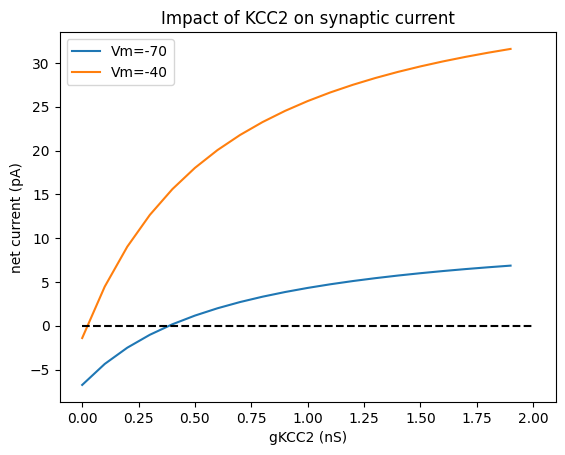

In [45]:

plt.plot(gKCC2_vec,Ivec_m70, gKCC2_vec,Ivec_m40,[0,2],[0,0],'--k')
plt.xlabel('gKCC2 (nS)')
plt.ylabel('net current (pA)')
plt.legend(['Vm=-70', 'Vm=-40'])
plt.title('Impact of KCC2 on synaptic current')
plt.show()

We use the convention that a positive current is hyperpolarizing (inhibitory) and the a negative current is depolarizing (excitatory).

Remark that the polarity of the net current is reversed for very small values of KCC2 activity.

In this last example, we computed a *static* value of chloride concentration.

However, as membrane potential and other variables describing cell properties,ionic concentrations also evolve dynamically.

The general formula describing the evolution of intracellular chloride
$$
\frac{d[Cl^-]_i}{dt}=\frac{I_{Cl}}{F\cdot \mathrm{Vol}}.
$$
Here $Vol$ is the cell volume and as above $F$ is the Faraday constant.   

Because of the magnitude of the constant $F\cdot \mathrm{Vol}$, the dynamics of chloride concentration is typical slower than the dynamics of the membrane potential.

**Remark:**  $I_{Cl}$ stands for the total transmembrane current. It includes the chloride current through KCC2 even thoug there is not net current through KCC2 as the chloride current is balanced by the potassium current.

To visualize the dynamics of chloride  concentration, we simulate an example in which GABA synapses are activated at a sustained frequency.

At the begining of the simulation, the synaptic current is hyperpolarizing.

As chloride concentration increases, the GABA synaptic potential becomes more depolarized and the synaptic current becomes depolarizing.


In [46]:
def Dynamic_Cl(gKCC2):
  #Computes the time course of chloride concentration
  #INPUT: gKCC2, a real number, the strength of the KCC2 cotransporter
  #OUTPUT
  #TVec, a list of positive real numbers, time points of the simulation
  #gGABAVec,  a list of real numbers, GABA conductance
  #VmVec, a list of real number, membrane potential
  #cliVec, a list of positive real numbers, chloride concentration
  #IGabVec, a list of real numbers, synaptic current


  #Defining the constants
  R=8.3144
  T=310
  F=96485

  #Parameters of the model
  EK=-100 #(mV) potassium reversal potential
  EL=-60#(mV) leak potential
  gL=10#(nS) leak conductance
  gLCl=0.5
  gGABAmax=10 #(nS) maximal gaba conductance
  Vol=500 #(um3) cell volume
  tauGABA=20# (ms) time constant of GABA conductance
  duration_pre=20000 #(ms) We let the simulation run before synaptic events to let the concentration reach equilibrium
  duration_sim=1000 #(ms) duration of the synaptic burst
  dt=0.05 #(ms) time step
  freq=50 #  (Hz) frequency of synaptic events
  clo=140 #(mM) extracellular chloride concentration
  HCO3i=15 #(mM) intracellular bicarbonate concentration
  HCO3o=35 #(mM) extracellular bicarbonate
  Cm=1#(pF)  Membrane capacitance
  EHCO3=1000*(R*T/F)*np.log(HCO3i/HCO3o) #(mV) bicarbonate reversal potential

  #Initializing variables
  Inter=int(((1000/freq)/dt))
  Ntime=int(np.floor((duration_pre+duration_sim)/dt))
  TVec=[]
  gGABAVec=[]
  VmVec=[]
  cliVec=[]
  IGabVec=[]
  gGABA=0
  cli=10
  ECl=1000*(R*T/F)*np.log(cli/Clo)
  Vm=-60

  #begining the main loop
  for t in range(Ntime):
    time=t*dt
    if (np.floor(t/Inter)==t/Inter) and (time>duration_pre+100):
      gGABA=gGABA+gGABAmax
    gGABA=gGABA*(1-dt/tauGABA)
    ICl=0.8*gGABA*(ECl-Vm)
    IlCl=gLCl*(ECl-Vm)#pA
    IHCO3=0.2*gGABA*(EHCO3-Vm)#pA
    Ileak=gL*(EL-Vm)#pA
    IKCC2=gKCC2*(EK-ECl)
    cli=cli+dt*(1000*(-ICl-IlCl+IKCC2))/(F*Vol)
    Vm=Vm+dt*(ICl+IHCO3+Ileak)/Cm
    ECl=1000*(R*T/F)*np.log(cli/Clo)
    if time>duration_pre:
      VmVec.append(Vm)
      cliVec.append(cli)
      IGabVec.append(ICl+IHCO3)
      TVec.append(time-duration_pre)
      gGABAVec.append(gGABA)

  return TVec, gGABAVec, VmVec, cliVec, IGabVec





Let's launch the simulation and plot the results

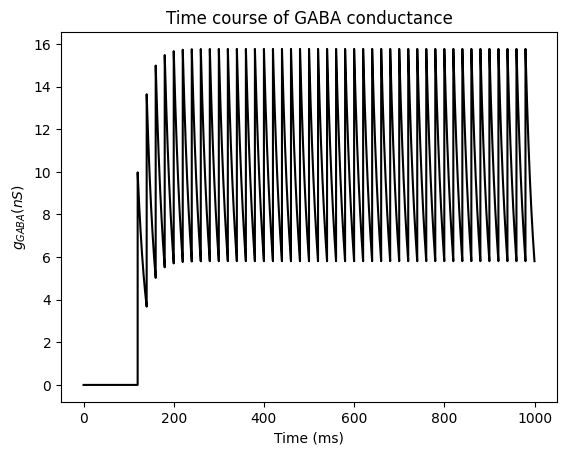

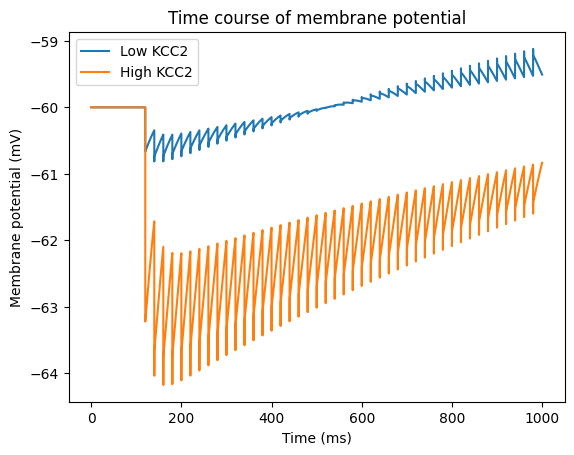

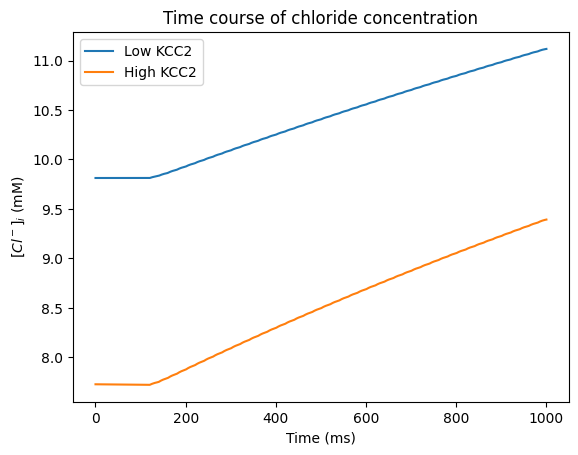

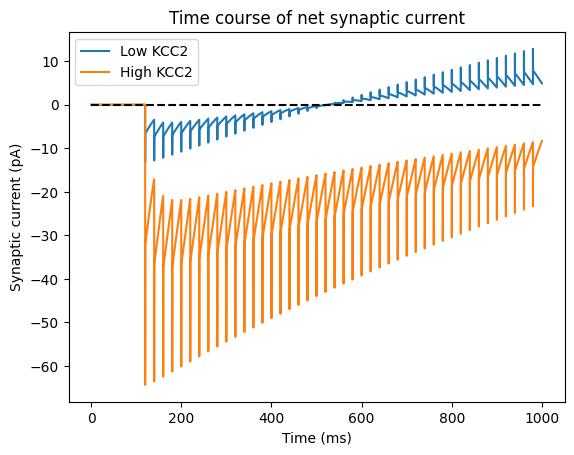

In [53]:
#Launching the simulation with low KCC2 activity
TimeVec02, gGABAVec02, VmVec02, cliVec02, IGabVec02=Dynamic_Cl(0.2)

#Launching the simulation with high KCC2 activity
TimeVec05, gGABAVec05, VmVec05, cliVec05, IGabVec05=Dynamic_Cl(0.5)

#Plotting the results
plt.plot(TimeVec02,gGABAVec02,'-k')
plt.xlabel('Time (ms)')
plt.ylabel('$g_{GABA} (nS)$')
plt.title('Time course of GABA conductance')
plt.show()


plt.plot(TimeVec02,VmVec02,TimeVec05,VmVec05)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Time course of membrane potential')
plt.legend(['Low KCC2','High KCC2'])
plt.show()

plt.plot(TimeVec02,cliVec02,TimeVec05,cliVec05)
plt.xlabel('Time (ms)')
plt.ylabel('$[Cl^-]_i$ (mM)')
plt.title('Time course of chloride concentration')
plt.legend(['Low KCC2','High KCC2'])
plt.show()

plt.plot(TimeVec02,IGabVec02,TimeVec05,IGabVec05,[0,1000],[0,0],'--k')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')
plt.title('Time course of net synaptic current')
plt.legend(['Low KCC2','High KCC2'])
plt.show()






The time course of synaptic current is of particular interest.  We observe that when KCC2 activity is low, due to chloride accumulation, the current become depolarizing after about 500 ms.

#### **Exercices**

*   Repeat the above simulation with other values of KCC2 activity
*   NKCC1 is a chloride cotransporter expressed in the young. It normally imports chloride into the cell.  Two chloride ions are moved accross the membrane together with one sodium ion and one potassium ion.
The equation giving chloride current through KCC2 is
$$
g_{NKCC1}(2E_{Cl}-E_K-E_{Na}).
$$
Typical values of $E_{Na}$ are around 45 mV.
Replace KCC2 by NKCC1 in the above model

#### **Spike timing dependant plasticity**

Synaptic weights evolve with time according to neural activity.

This raises an important question:  *How is information transmitted to the synapse?*

In other words:  *How does the synapse know it has to change its strength?*

The signalling pathway is

**Neural activity->intracellular calcium conctration->molecular mechanisms
->Synaptic weight.**

The chain of intracellular reactions triggered by calcium influx and lead to change in synaptic strength is complicated. We will not describe it here.

Both prespynaptic and postysnpatic action potentials lead to increase in calcium concentration in the synapse.

The synapse will grow stronger if a presynaptic action potential is shortly followed by a postsynaptic action potential.

This is refered to as Spike Timing dependant plasticity (STDP).

We will follow the paper given in the link

https://www.pnas.org/doi/epdf/10.1073/pnas.1109359109

We first generate random sequences of pre and post synaptic spikes

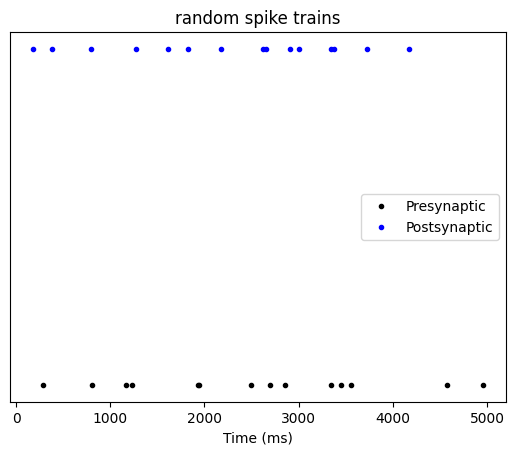

In [62]:
from matplotlib import pyplot as plt

#Generating the spike trains
prob_pre_spike=0.003
prob_post_spike=0.003
pre_spike=[]
post_spike=[]
Time=5000
for t in range(Time):
  r=np.random.random()
  if r<prob_pre_spike:
    post_spike.append(t)
  r=np.random.random()
  if r<prob_pre_spike:
    pre_spike.append(t)

#Plotting the results
plt.plot(pre_spike, np.repeat(1,len(pre_spike)),'.k',post_spike, np.repeat(2,len(post_spike)),'.b')
plt.xlabel('Time (ms)')
plt.yticks([])
plt.legend(['Presynaptic','Postsynaptic'])
plt.title('random spike trains')
plt.show()



The calcium concentration increases of a result of either a presynaptic or a postsynaptic action potential.

A presynaptic action potential will cause the opening of NMDA channels permeable to calcium ions.  These channels are slow and their opening is delayed.

A postsynaptic action potential causes the opening of voltage gated calcium channels.

Let's simulate the calcium concentration response to the above trains of action potentials.

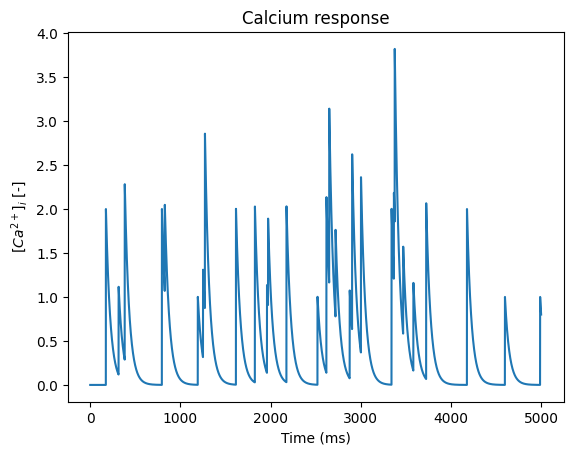

In [63]:
def calrep(pre_spike,post_spike,Time):
  #computes the time course of calcium concentration in response to spike trains
  #INPUT:
  #pre_spike, a list of real numbers, the time of occurrance of presynaptic spikes
  #post_spike, a list of real numbers, the time of occurrance of postsynaptic spikes
  #Time, a real number, duration of the simulation
  #OUTPUT
  #tvec, a list of positive reals, time points of the simulation
  #calvec, a list of positive reals, calcium concentration

  calvec=[]
  tvec=[]
  taucal=50#time constant of calcium dynamics
  delta=25# delay between presynaptic spike and calcium response.
  calcium=0 #initial calcium concentration


  for t in range(Time):
    tvec.append(t)
    if t-delta in pre_spike:
      calcium=calcium+1
    if t in post_spike:
      calcium=calcium+2
    calvec.append(calcium)
    calcium=calcium*(1-1/taucal)
  return tvec, calvec

#Launching the simulation
tvec,calvec=calrep(pre_spike,post_spike,Time)

#Plotting the results
plt.plot(tvec,calvec)
plt.xlabel('Time (ms)')
plt.ylabel('$[Ca^{2+}]_i$ [-]')
plt.title('Calcium response')
plt.show()



The synaptic weight evolve in a rather complicated way as a function of calcium concentration.

1.   If the calcium concentration is smaller than a first threshold $[Ca^{2+}]_i<\theta_d$, the synaptic weight doesn't change.
2.   If the calcium concentration is between two thresholds $\theta_d<[Ca^{2+}]_i<\theta_p$, the synaptic weigth decreases.
3.   If the calcium concentration is larger than a second threshold $[Ca^{2+}]_i>\theta_p$, the synaptic weigth increases.



In [64]:
def synplas(calcvec,Time):
  #Computes the time course of synpatic weight
  #INPUT:
  #calcvec, a list of real numbers, calcium concentration
  #Time, a positive real number, duration of the simulation
  #OUTPUT:
  # timevec, a list of real numbers, time points of the simulation
  # rhovec, a list of real numbers, synaptic weight


  timevec=[]
  rhovec=[]
  rho=0.5 #initial value of synaptic weight
  gammap=0.02
  gammad=0.0105
  thetad=1
  thetap=1.3
  for t in range(Time):
    if calvec[t]>thetad:
      rho=rho-rho*gammad
    if calvec[t]>thetap:
      rho=rho+(1-rho)*gammap
    timevec.append(t)
    rhovec.append(rho)
  return timevec,rhovec





We can simulate the evolution of the synaptic weigth as a response of the time dependant calcium concentration computed above.

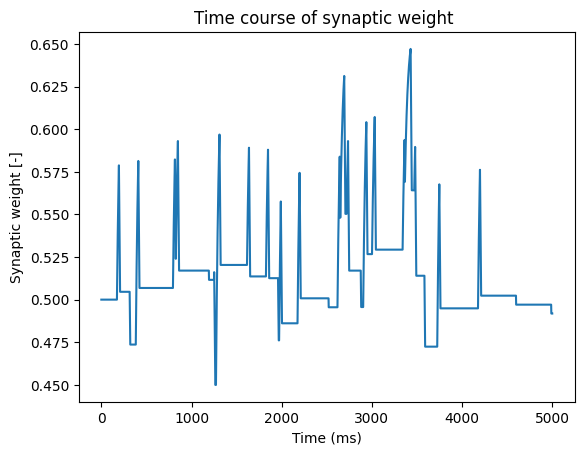

In [65]:
#Launching the simulation
timevec,rhovec=synplas(calvec,Time)

#Plotting the result
plt.plot(timevec,rhovec)
plt.ylabel('Synaptic weight [-]')
plt.xlabel('Time (ms)')
plt.title('Time course of synaptic weight ')
plt.show()

**Remark:** This graph is not very usefull.
The real time evolution of synaptic weigth has no functional significance and cannot be directly measured.

What is relevant is to submit the synapse to pair of pre and post synaptic action potentials.

For different delays between the pre and post action potentials, we measure the relative change in synaptic weight resulting from this activity.

The post synaptic action potential can occur before or after the pre synaptic one.

We expect that the synaptic weight increases when the presynaptic activity causes the postsynaptic neuron to fire, so when the post synaptic action potential occurs after the presynaptic one.


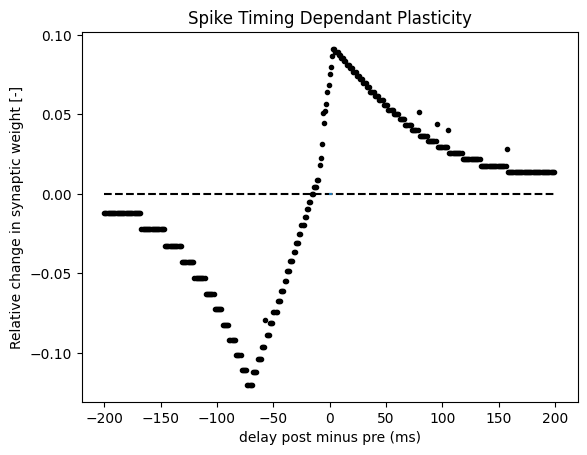

In [67]:

#Launching the simulations
pre_spike=[400]
post_spike=[100]
Time=800


delta_rho_vec=[]
delta_time_vec=[]
for j in range(400):
  delta_time=j-200
  post_spike=[400+delta_time]
  tvec,calvec=calrep(pre_spike,post_spike,Time)
  tvec,rhovec=synplas(calvec,Time)
  delta_rho_vec.append((rhovec[-1]-0.5)/0.5)
  delta_time_vec.append(delta_time)

#plotting the results
plt.plot(delta_time_vec,delta_rho_vec,'.k',[-200, 200],[0, 0],'--k',[0, 0])
plt.xlabel('delay post minus pre (ms)')
plt.ylabel('Relative change in synaptic weight [-]')
plt.title('Spike Timing Dependant Plasticity')
plt.show()

#### **Exercice**

Open the research paper: https://www.pnas.org/doi/epdf/10.1073/pnas.1109359109

Relaunch the above sets of simulations with different values of $\theta_d$, $\theta_p$, $\gamma_d$ and $\gamma_p$ to obtain different profiles of spike timing dependant plasticity.